###### Dimensionality Reduction Starter Coder 
# Version 6 includes TFIDF Cosine Similarity Starter Code
# Doc2Vec and Word2Vec
# TSNE visualization and K-Means document listings are provided to help you perform analysis
## 2021Spr_MSDS_453-DL_SEC56
### jennifer.sleeman@northwestern.edu, paulhuynh2018@u.northwestern.edu



In [38]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pandas as pd
import os
import numpy as np
import phrasemachine
from rake_nltk import Rake
import re
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
import gensim




In [39]:
#################################################################################
#An Example of One-hot encoding  
#Very Simple Based on example in Deep Learning for Natural Language Processing
#################################################################################
# define example
data = ['ginsburg', 'RBG', 'justice', 'ginsburg']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
#print(onehot_encoded[0, :])
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
#print(inverted)

['ginsburg' 'RBG' 'justice' 'ginsburg']
[1 0 2 1]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [40]:
# Only run this once, they will be downloaded.
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulhuynh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulhuynh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [42]:
# Pre-process dataset to remove punctuation
def remove_punctuation(in_text):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(in_text))
    return text

In [43]:
# Pre-process dataset to lower case it
def lower_case(in_text):
    # Convert to lowercase
    text = in_text.lower()    
    return text

In [44]:
# Pre-process dataset to remove tags
def remove_tags(in_text):    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",in_text)
    return text

In [45]:
# Pre-process dataset to remove special characters and digits
def remove_special_chars_and_digits(in_text):
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",in_text)
    return text


In [46]:
# Pre-process dataset to appy Stemming
def apply_stemming(in_text):
    stemmer=PorterStemmer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([stemmer.stem(w) for w in word_list])
    return output

In [47]:
# Pre-process dataset to apply Lemmatization
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

In [48]:
# Remove stop words
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return filtered_sentence

In [49]:
# Run Phase Machine
def run_phrase_machine(in_text):
    phrases=phrasemachine.get_phrases(in_text)
    return phrases

In [50]:
#Run Rake Keyword Extractor
def run_rake(in_text):
    r = Rake()
    r.extract_keywords_from_text(in_text)
    rake_phrases= r.get_ranked_phrases()
    return rake_phrases

In [51]:
# Run NLTK Tokenizer
def run_nltk_tokenizer(in_text):
    tokens=nltk.word_tokenize(in_text)
    return tokens

In [52]:
# Run NLTK Sentence Tokenizer
def run_nltk_sent_tokenizer(in_corpus):
    sents = nltk.sent_tokenize(in_corpus)
    return sents

In [53]:
#Run word-ngram Tokenizer
def run_nltk_tokenizer_word_ngrams(in_text, ngram_size):
    n_grams = ngrams(nltk.word_tokenize(in_text), ngram_size)
    return [ ' '.join(grams) for grams in n_grams]

In [54]:
#Get Frequ Dist 
def get_freq_dist(terms):
    all_counts = dict()
    all_counts[size] = FreqDist(terms)
    return all_counts

In [55]:

###############################################################################
### Processing text into lists
###############################################################################
def get_corpus(path_to_file):
    #read in class corpus csv into python
    data=pd.read_csv(path_to_file)

    #create empty list to store text documents titles
    titles=[]
    docids=[]
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        docids.append(data['Doc_ID'].iloc[i])

    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        titles.append(data['DSI_Title'].iloc[i])

    #create empty list to store text documents
    text_body=[]

    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    return (docids,titles,text_body)

In [56]:
###############################################################################
### Functions to visualize documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    doc = ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)

    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    
    return tokens

def process_corpus(data):
        
    #create empty list to store text documents titles
    titles=[]
    
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        temp_text=data['DSI_Title'].iloc[i]
        titles.append(temp_text)
    
    #create empty list to store text documents
    text_body=[]
    
    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    
    #Note: the text_body is the unprocessed list of documents read directly form 
    #the csv.
        
    #empty list to store processed documents
    processed_text=[]
    #for loop to process the text to the processed_text list
    for i in text_body:
        text=clean_doc(i)
        processed_text.append(text)
    
    #Note: the processed_text is the PROCESSED list of documents read directly form 
    #the csv.  Note the list of words is separated by commas.
    
    
    #stitch back together individual words to reform body of text
    final_processed_text=[]
    
    for i in processed_text:
        temp_DSI=i[0]
        for k in range(1,len(i)):
            temp_DSI=temp_DSI+' '+i[k]
        final_processed_text.append(temp_DSI)
    
    return titles, final_processed_text, processed_text

def run_doc2vec(final_processed_text, processed_text):
    #create doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
    model = Doc2Vec(documents, vector_size=100, window=3, min_count=2, workers=4)    
    
    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
        
    return doc2vec_df

def run_word2vec(processed_text):

    #word to vec model
    model_w2v = Word2Vec(processed_text, size=100, window=3, min_count=2, workers=4)
    
    labels = []
    tokens = []

    for word in model_w2v.wv.vocab:
        tokens.append(model_w2v[word])
        labels.append(word)
    
    
    return labels, tokens, model_w2v





def plot_doc2vec(doc2vec_df, titles,_perplexity=10):
    #visualize documents through applying TSNE to doc2vec matrix
    tsne_model = TSNE(perplexity=_perplexity, n_components=2, init='pca', n_iter=2500, random_state=23)
    doc2vec_df = tsne_model.fit_transform(doc2vec_df)
    x = []
    y = []
    for value in doc2vec_df:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(titles[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

def plot_word2vec(model, labels, tokens, _perplexity=30):
    "Creates and TSNE model and plots it"
    words = []
    embeddings = []
    for word in list(model.wv.vocab):
        embeddings.append(model.wv[word])
        words.append(word)

    tsne_model= TSNE(perplexity=_perplexity, n_components=2, init='pca', n_iter=3500, random_state=32)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(40, 40)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    

In [57]:
###############################################################################
### Setup path to file, get the corpus, set up 
###############################################################################
path_to_file='/Users/paulhuynh/Documents/School/2021 Summer/Section 56/453_Sec55_Class_Corpus.csv'
docids,titles,text=get_corpus(path_to_file)
print(titles)





['AJP_Doc10_For_Arrival_Is_A', 'AJP_Doc1_Denis_Villeneuves_Arrival', 'AJP_Doc2_Arrival_Arrives_Just', 'AJP_Doc3_The_Prescient_Wisdom', 'AJP_Doc4_Arrival_Is_A', 'AJP_Doc5_Arrival_Is_The', 'AJP_Doc6_Denis_Villeneuve_Wants', 'AJP_Doc7_Star_Studded_Arrival', 'AJP_Doc8_Arrival_The_Film', 'AJP_Doc9_For_A_Film', 'ARR_Doc10_James_Bond_Casino_Royale_Review_Negative', 'ARR_Doc1_James_Bond_Casino_Royale_Review_Positive', 'ARR_Doc2_James_Bond_Casino_Royale_Review_Positive', 'ARR_Doc3_James_Bond_Casino_Royale_Review_Positive', 'ARR_Doc4_James_Bond_Casino_Royale_Review_Positive', 'ARR_Doc5_James_Bond_Casino_Royale_Review_Positive', 'ARR_Doc6_James_Bond_Casino_Royale_Review_Negative', 'ARR_Doc7_James_Bond_Casino_Royale_Review_Negative', 'ARR_Doc8_James_Bond_Casino_Royale_Review_Negative', 'ARR_Doc9_James_Bond_Casino_Royale_Review_Negative', 'AZ_Doc10_pirates_of_the_caribbean_the_curse_of_the_black_pearl', 'AZ_Doc1_pirates_of_the_caribbean_the_curse_of_the_black_pearl', 'AZ_Doc2_pirates_of_the_caribbe

In [58]:
#Obtains the words count frequencies across corpus

vectorizer = CountVectorizer(ngram_range = (1,1))
matrix=vectorizer.fit_transform(text)     

#creating datafram from TFIDF Matrix
words = vectorizer.get_feature_names()
matrix=pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names(), index=titles)

frequencies = matrix.sum().transpose().reset_index()

frequencies.columns = ['word', 'counts']

frequencies.head(10)

word  counts
0            00       4
1           000       4
2  0000779fd2ac       2
3      002aafce       1
4           007      17
5          00pm       2
6            01       5
7            02       4
8            03       5
9            04       5

In [59]:
###############################################################################
### Calculates TFIDF and Saves TFIDF values for terms to a file
###############################################################################
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, norm=None)
transformed_documents = vectorizer.fit_transform(text)
transformed_documents_as_array = transformed_documents.toarray()

####################################################################################
# NOTE THIS SAVE A FILE FOR EACH DOCUMENT TO YOUR HARD DRIVE
# It first creates a directory called td_idf_output
# Then for each document it will generate a file with the words and tf idf scores
###################################################################################
output_dir ="td_idf_output"

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for counter, doc in enumerate(transformed_documents_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

    # output to a csv using the enumerated value for the filename
    one_doc_as_df.to_csv(output_dir+"/"+str(titles[counter]))
    


In [64]:
data = pd.read_csv(path_to_file)

In [65]:
#create word and document embedding

#cleans text to get processed text
titles, final_processed_text, processed_text = process_corpus(data)


#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

w2v_df.head(10)

0         1   \
slaughterfest                                      -0.005154  0.001363   
oyelowo                                             0.002691  0.003547   
thinly                                              0.002494 -0.003025   
missionwe                                           0.004011  0.001028   
expectation                                         0.000664  0.006088   
acknowledges                                        0.004650  0.001361   
battleshippretensioncomthemartiansolomissionbyr...  0.002554  0.004960   
staccato                                            0.001621  0.000631   
rousts                                             -0.001802  0.001537   
evolves                                            -0.002920 -0.002480   

                                                          2         3   \
slaughterfest                                       0.002585 -0.002237   
oyelowo                                             0.004657  0.000868   
thinly                                             -0.003666  0.000029   
missionwe                                           0.003284 -0.005021   
expectation                                         0.005951 -0.002311   
acknowledges                                        0.000098 -0.003388   
battleshippretensioncomthemartiansolomissionbyr...  0.001017 -0.004453   
staccato                                           -0.003480 -0.004127   
rousts                                             -0.000329  0.003561   
evolves                                             0.003465  0.000195   

                                                          4         5   \
slaughterfest                                       0.000109  0.002315   
oyelowo                                             0.000684  0.001960   
thinly                                             -0.004301  0.002617   
missionwe                                          -0.005221  0.001935   
expectation                                         0.002035  0.003442   
acknowledges                                       -0.004470 -0.002017   
battleshippretensioncomthemartiansolomissionbyr... -0.000150 -0.002492   
staccato                                           -0.005094  0.000409   
rousts                                             -0.000089  0.003791   
evolves                                             0.002703 -0.000551   

                                                          6         7   \
slaughterfest                                       0.001600  0.002702   
oyelowo                                             0.000653  0.003346   
thinly                                              0.004726 -0.004158   
missionwe                                           0.004878  0.003265   
expectation                                         0.004497 -0.006271   
acknowledges                                        0.000284 -0.002361   
battleshippretensioncomthemartiansolomissionbyr... -0.002390  0.001676   
staccato                                           -0.001774  0.001127   
rousts                                             -0.003627 -0.004453   
evolves                                             0.001487  0.000717   

                                                          8         9   ...  \
slaughterfest                                      -0.000233  0.000570  ...   
oyelowo                                             0.003344  0.001518  ...   
thinly                                              0.004599  0.002979  ...   
missionwe                                          -0.001354 -0.002283  ...   
expectation                                         0.000781  0.000204  ...   
acknowledges                                        0.001871 -0.003252  ...   
battleshippretensioncomthemartiansolomissionbyr...  0.002481 -0.001114  ...   
staccato                                            0.003980 -0.001800  ...   
rousts                                             -0.004564  0.000279  ...   
evolves 

In [66]:
###############################################################################
### Create Doc2Vec Embedding
###############################################################################
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=1000, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([t, doc2vec_df], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_df.head(10)

title         0         1         2         3  \
0          AJP_Doc10_For_Arrival_Is_A  0.000129 -0.000342  0.000332  0.000417   
1  AJP_Doc1_Denis_Villeneuves_Arrival -0.000153  0.000035  0.000100 -0.000073   
2       AJP_Doc2_Arrival_Arrives_Just  0.000007  0.000306 -0.000384 -0.000491   
3       AJP_Doc3_The_Prescient_Wisdom -0.000044  0.000355  0.000031 -0.000384   
4               AJP_Doc4_Arrival_Is_A  0.000064 -0.000090  0.000373  0.000426   
5             AJP_Doc5_Arrival_Is_The -0.000318 -0.000003 -0.000156  0.000030   
6     AJP_Doc6_Denis_Villeneuve_Wants  0.000208 -0.000302 -0.000449 -0.000371   
7       AJP_Doc7_Star_Studded_Arrival -0.000045 -0.000026  0.000438  0.000392   
8           AJP_Doc8_Arrival_The_Film -0.000467  0.000153  0.000484  0.000141   
9                 AJP_Doc9_For_A_Film -0.000120  0.000356  0.000334 -0.000190   

          4         5         6         7         8  ...       990       991  \
0  0.000252  0.000421  0.000310  0.000146 -0.000225  ... -0.000443 -0.000191   
1  0.000229 -0.000325  0.000096 -0.000087  0.000340  ...  0.000398  0.000033   
2  0.000070 -0.000381 -0.000084 -0.000221  0.000444  ...  0.000380  0.000122   
3  0.000122  0.000373 -0.000401 -0.000390 -0.000446  ...  0.000290 -0.000177   
4 -0.000350 -0.000177 -0.000093 -0.000187 -0.000190  ... -0.000327  0.000399   
5  0.000055 -0.000225  0.000494 -0.000324 -0.000278  ... -0.000489  0.000256   
6 -0.000182 -0.000459  0.000422 -0.000288  0.000449  ...  0.000429 -0.000093   
7 -0.000141 -0.000179 -0.000107  0.000445  0.000496  ... -0.000463  0.000486   
8  0.000100 -0.000366 -0.000067  0.000122 -0.000339  ... -0.000062  0.000183   
9  0.000198 -0.000223  0.000250 -0.000066  0.000384  ...  0.000015 -0.000165   

        992       993       994       995       996       997       998  \
0  0.000488 -0.000078 -0.000227  0.000440  0.000411  0.000148  0.000224   
1 -0.000144  0.000406 -0.000308  0.000410  0.000179  0.000342 -0.000470   
2  0.000428 -0.000356 -0.000002 -0.000236 -0.000332 -0.000200  0.000197   
3 -0.000089  0.000011 -0.000404  0.000472 -0.000361 -0.000240 -0.000377   
4 -0.000028 -0.000445 -0.000379  0.000102 -0.000018 -0.000307 -0.000085   
5  0.000032  0.000066  0.000222  0.000055  0.000320  0.000249 -0.000334   
6 -0.000445  0.000401 -0.000335  0.000420 -0.000117  0.000485  0.000150   
7 -0.000314  0.000241  0.000406  0.000429  0.000058  0.000182  0.000428   
8  0.000168  0.000352 -0.000271 -0.000142 -0.000377 -0.000003  0.000403   
9  0.000232 -0.000150  0.000372 -0.000051  0.000293 -0.000004  0.000051   

        999  
0  0.000254  
1  0.000497  
2 -0.000112  
3  0.000178  
4  0.000482  
5 -0.000478  
6 -0.000470  
7 -0.000215  
8  0.000238  
9  0.000331  

[10 rows x 1001 columns]

In [67]:
###############################################################################
### Calculates the Cosine Similarity across your corpus using TFIDF matrix
###############################################################################
doc_term_matrix = transformed_documents.todense()
df = pd.DataFrame(doc_term_matrix, 
                      columns=vectorizer.get_feature_names(), 
                      index=docids)
   
similarity  = cosine_similarity(df, df)

In [68]:
similarity.shape

(200, 200)

<AxesSubplot:>

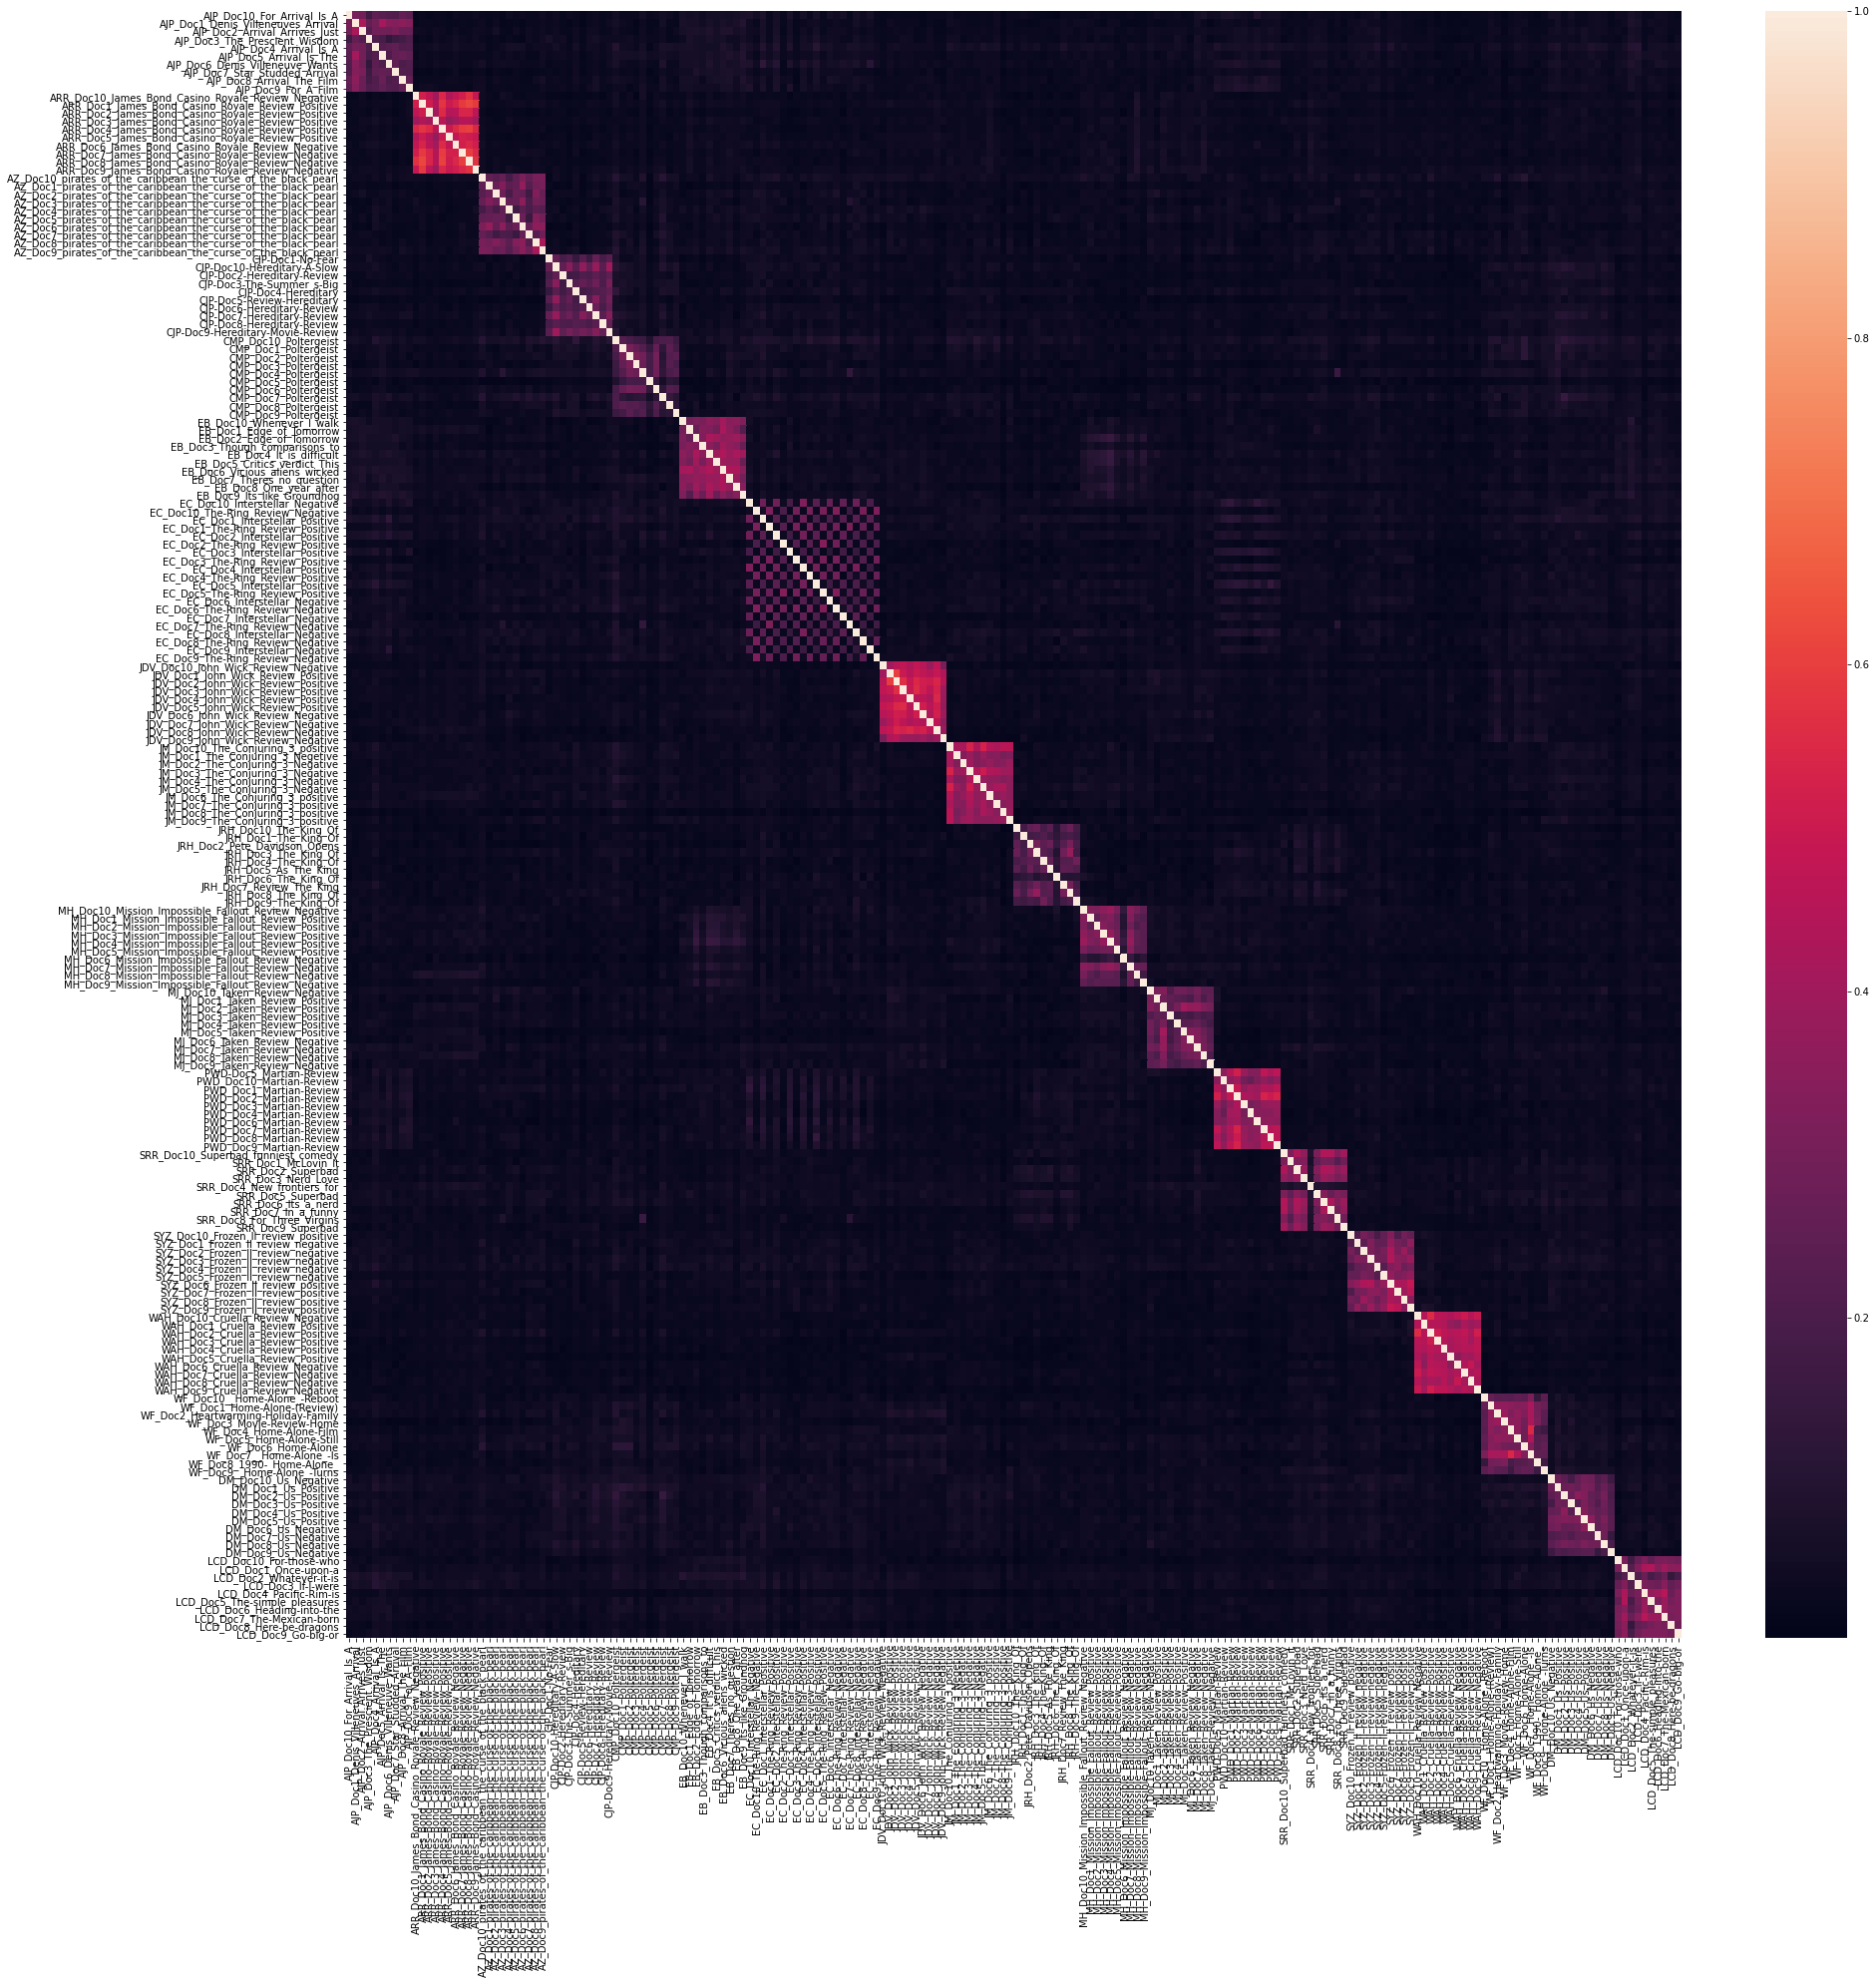

In [69]:
#heatmap of cosine similarity of documents
similarity  = cosine_similarity(df, df)

import seaborn as sns

from matplotlib import pyplot
import seaborn


a4_dims = (30, 30)

fig, ax = pyplot.subplots(figsize=a4_dims)

seaborn.heatmap(ax=ax, data=similarity, xticklabels= titles, yticklabels=titles)




In [77]:
#load class corpus
data=pd.read_csv(path_to_file)

In [78]:
# =============================================================================
# Running functions to (1): process documents, (2) create doc2vec matrix, and
# (3)plotting with TSNE
# =============================================================================
#process documents
titles, final_processed_text, processed_text = process_corpus(data)
print(final_processed_text[0])



title arrival waste space author sourcedate observer canadian director denis villeneuve great called prisoners provocative enthralling beautifully composed peeled layer complex mystery story surprise every frame instant promising relationship heartbreaking finale every since enemy sicario unspeakable disaster arrival director latest exercise pretentious poopery every reason believe parted company denis villeneuve anchorman every channel unidentified flying saucer landed throughout world place afield russia venezuela montana borders closed donald trump limited supply escape president declares state emergency enter adams linguistics professor louise banks jeremy renner theoretical physicist donnelly recruited military alien decipher language translation never jodie foster already solved problem contact adams neurotic shortfused still grieving disappearance husband daughter inexplicable disease traveled outer space think cancer movie cancer seems logical anyway spaceship obeliskshaped sus

In [79]:
doc2vec_df = run_doc2vec(final_processed_text, processed_text)

labels, tokens, word2vec_model = run_word2vec(processed_text)

print(len(tokens))

6479


<ipython-input-56-e3bfc0d2aa04>:86: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model_w2v[word])


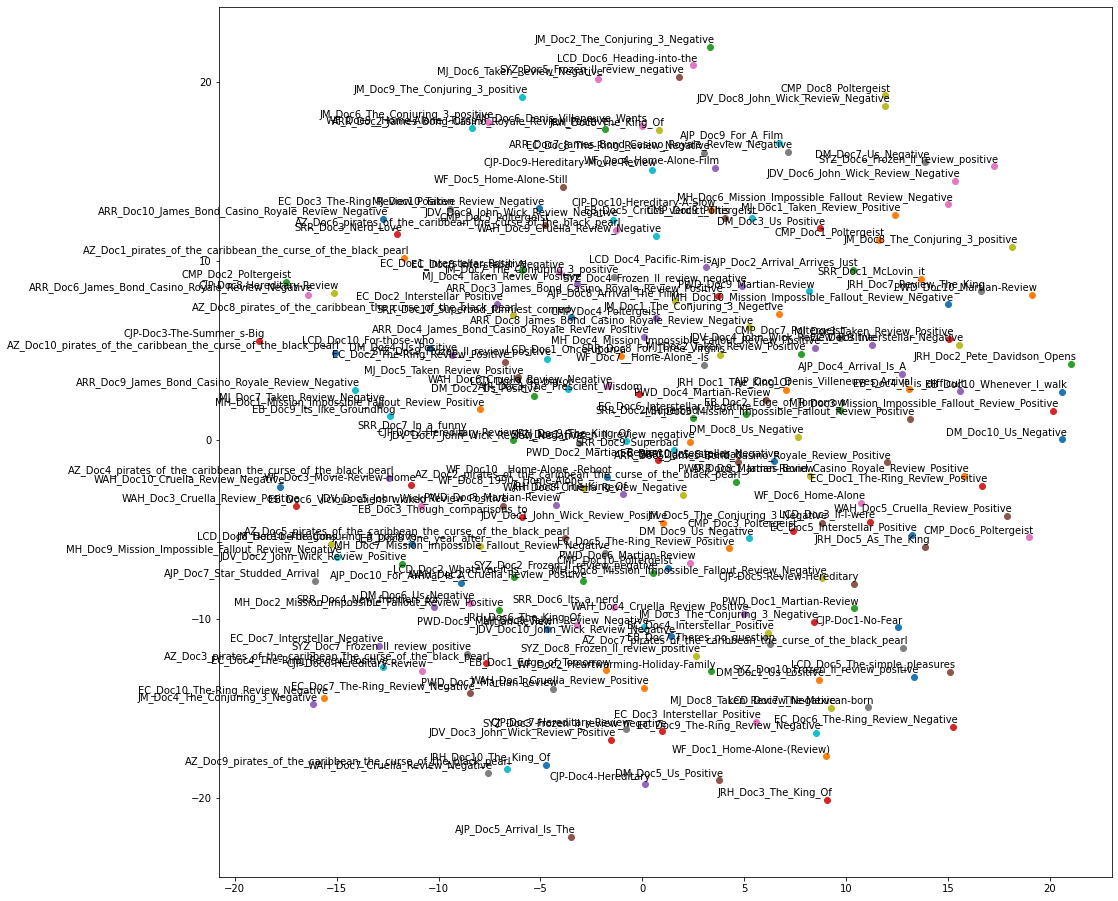

In [80]:
#plot doc2vec via TSNE
plot_doc2vec(doc2vec_df, titles,15)

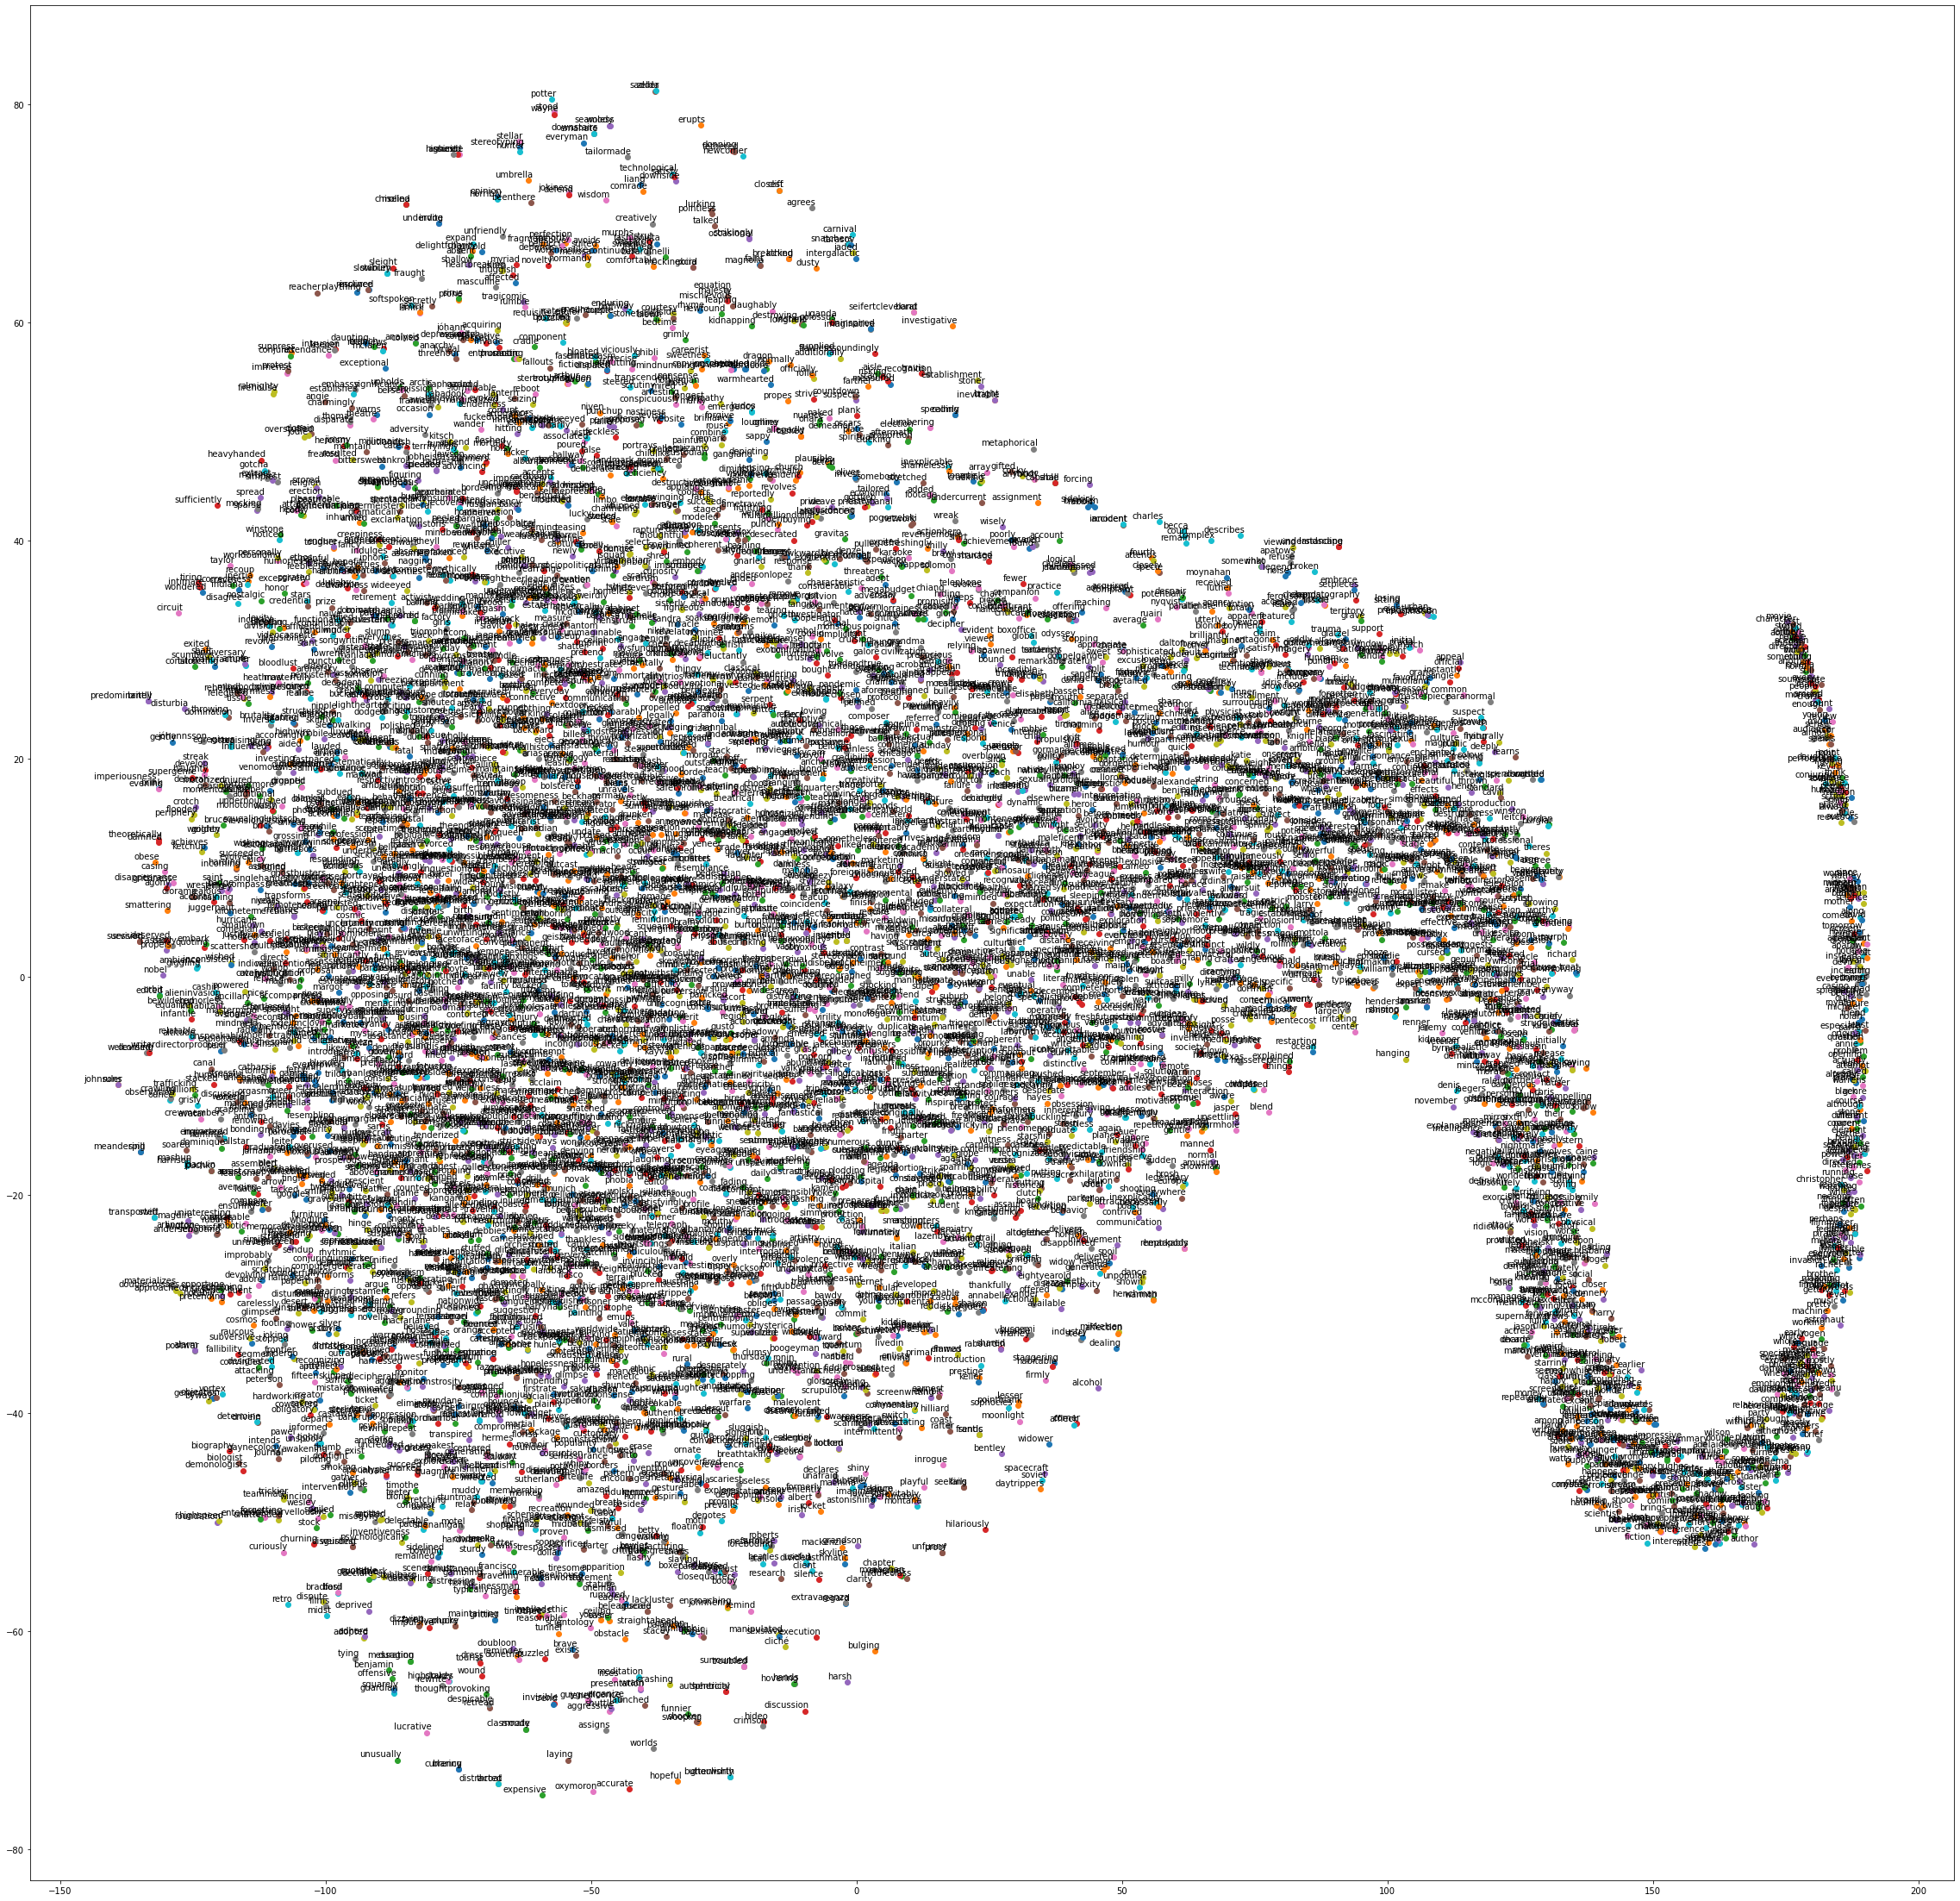

In [81]:
#plot word2vec via TSNE
plot_word2vec(word2vec_model, labels, tokens,20)

In [86]:
#############################################
#Explore K-means clustering of tfidf matrix
#############################################

#############################################
#Calculates tf idf
#Edit ngram range if you like
#############################################
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(stop_words='english', ngram_range = ngram_range)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

#############################################
#Performs the k-means clustering of the tfidf matrix
#Edit the number of clusters
#############################################
def k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=10):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]


    #save the terms for each cluster and document to dictionaries.  To be used later
    #for plotting output.

    #dictionary to store terms and titles
    cluster_terms={}
    cluster_title={}


    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
        cluster_terms[i]=temp_terms

        print("Cluster %d titles:" % i, end='')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            print(' %s,' % title, end='')
            temp_titles.append(title)
        cluster_title[i]=temp_titles
        

#############################################
# Run the code
#############################################
tfidf_matrix, terms = tfidf(final_processed_text, titles)
k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=15)

Top terms per cluster:
Cluster 0:
 pirate
 sparrow
 pirates
 johnny
 captain
 turner
 caribbean
 movie
 bloom
 barbossa
Cluster 0 titles: AZ_Doc10_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc1_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc2_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc3_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc4_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc5_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc6_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc7_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc8_pirates_of_the_caribbean_the_curse_of_the_black_pearl, AZ_Doc9_pirates_of_the_caribbean_the_curse_of_the_black_pearl,Cluster 1:
 arrival
 louise
 alien
 villeneuve
 language
 adams
 scifi
 denis
 world
 banks
Cluster 1 titles: AJP_Doc10_For_Arrival_Is_A, AJP_Doc1_Denis_Villeneuves_Arrival, AJP_Doc2_Arrival_Arrives_Just, AJP_Doc3_The_Prescient_Wisd

In [87]:
#############################################
#Explore K-means clustering of doc2vec matrix
#############################################
def doc2vec_with_titles(corpus, processed_text, titles, vector_size = 100):
    #function to created doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    model = Doc2Vec(documents, vector_size=100, window=3, min_count=2, workers=4)

    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

    doc2vec_df=doc2vec_df.reset_index()

    doc_titles={'title': titles}
    t=pd.DataFrame(doc_titles)

    doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

    doc2vec_df=doc2vec_df.drop('index', axis=1)
    return doc2vec_df

def k_means_doc2vec(doc2vec_df, final_processed_text,titles, k = 5):
    
    #this is a funciton to create the k_means outputs using the doc2vec matrics.  Required inputs
    #include the doc2vec matrix, and desired number of clusters.
    doc2vec_k_means=doc2vec_df.drop('title', axis=1)

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(doc2vec_k_means)

    clusters_d2v = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        print("Cluster %d:" % i)
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            print(' %s ' % title, end='\n')
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

doc2vec_model = doc2vec_with_titles(final_processed_text, processed_text,titles)
doc2vec_model.index = titles
k_means_doc2vec(doc2vec_model, final_processed_text,titles, k =15)

Cluster 0:
 AZ_Doc7_pirates_of_the_caribbean_the_curse_of_the_black_pearl 
 JM_Doc10_The_Conjuring_3_positive 
 JM_Doc3_The_Conjuring_3_Negative 
 JRH_Doc6_The_King_Of 
 SYZ_Doc10_Frozen_II_review_positive 
 WAH_Doc10_Cruella_Review_Negative 
 DM_Doc4_Us_Positive 
 LCD_Doc5_The-simple_pleasures 
 LCD_Doc7_The-Mexican-born 
Cluster 1:
 ARR_Doc4_James_Bond_Casino_Royale_Review_Positive 
 CJP-Doc2-Hereditary-Review 
 CJP-Doc6-Hereditary-Review 
 EC_Doc5_Interstellar_Positive 
 JM_Doc5_The_Conjuring_3_Negative 
 JM_Doc9_The_Conjuring_3_positive 
 JRH_Doc5_As_The_King 
 MH_Doc7_Mission_Impossible_Fallout_Review_Negative 
 PWD_Doc6_Martian-Review 
 WF_Doc6_Home-Alone 
 LCD_Doc3_If-I-were 
Cluster 2:
 AJP_Doc5_Arrival_Is_The 
 AJP_Doc7_Star_Studded_Arrival 
 AJP_Doc8_Arrival_The_Film 
 CJP-Doc4-Hereditary 
 CMP_Doc3_Poltergeist 
 EC_Doc4_Interstellar_Positive 
 EC_Doc6_The-Ring_Review_Negative 
 MH_Doc9_Mission_Impossible_Fallout_Review_Negative 
 MJ_Doc4_Taken_Review_Positive 
 MJ_Doc9_Taken

In [88]:
#implementation of silhouette score to measure the most optimal number of clusters

k_list = [2, 5, 7, 10]

#silhoutte score list
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)
    
    


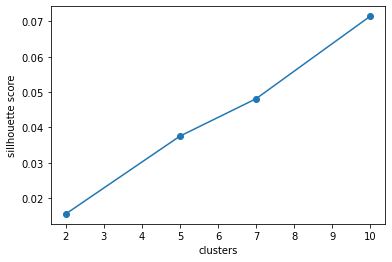

In [89]:
#plot silhouette scores in chart

import matplotlib.pyplot as plt


plt.scatter(k_list, sil_scores)
plt.plot(k_list, sil_scores)
plt.xlabel("clusters")
plt.ylabel("sillhouette score")
plt.show()